```
    ██╗   ██╗ ██████╗ ██╗      █████╗  ██████╗████████╗
    ╚██╗ ██╔╝██╔═══██╗██║     ██╔══██╗██╔════╝╚══██╔══╝
     ╚████╔╝ ██║   ██║██║     ███████║██║        ██║   
      ╚██╔╝  ██║   ██║██║     ██╔══██║██║        ██║   
       ██║   ╚██████╔╝███████╗██║  ██║╚██████╗   ██║   
       ╚═╝    ╚═════╝ ╚══════╝╚═╝  ╚═╝ ╚═════╝   ╚═╝ 
```
## Relevant paper
A simple, fully convolutional model for real-time instance segmentation.
- [YOLACT: Real-time Instance Segmentation](https://arxiv.org/abs/1904.02689)

# Relevant Theory
- Average slip and fall time is about 200-300 ms depending on the height of the person and the average speed they're walking at as they move into the fall. This means that images must be captured at a framerate of at least 5-6 FPS. 

- [Digital Image Processing Theory](http://omercetin.com.tr/DERS/IP/Kitap/2.Principles%20of%20digital%20image%20processing.pdf?i=1)

## Outstanding concerns
Need to construct a table of concerns for each method following the enumeration of the methods fleshed out below. 
- Not enough labelled polygons of people. This may complicate the faster buildout of this option. 


## Approach
        Part 1: 
        Video -> Instance Segmentation (People)

        Part 2:
        1. ML of feature space to separate out fall / no-fall for a single person in a single video. 
        2. OpticalFlow

        Part 3: 
        Video -> Instance Segmentation (People) -> SORT -> Inference of Part 2 features over time. 

## Summary


## Part 1: Run Inference on example video

In [26]:
from utils import VideoReaders, DetectorLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import segmentation
from itertools import groupby
import random
from SORT.sort import *

In [27]:
# Instantiate Model
frame_provider = VideoReaders.VideoReader('../datasets/slip-fall/fall-database/0026.mp4')
video_length, shape = frame_provider.properties()
model = DetectorLoader.YOLACT('./weights/yolact_resnet50_54_800000.pth', threshold = 0.11)

/home/ubuntu/anaconda3/envs/YOLACT/lib/python3.7/site-packages/torch/jit/_recursive.py:235: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/home/ubuntu/anaconda3/envs/YOLACT/lib/python3.7/site-packages/torch/jit/_recursive.py:235: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/home/ubuntu/anaconda3/envs/YOLACT/lib/python3.7/site-packages/torch/jit/_recursive.py:235: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [28]:
# Run model inference

output = []
frames = []
boundaries = []

for frame in frame_provider:
    frames.append(frame)
    c, s, bb, ma = model.predict(frame)
    idx = np.where(c == 0)
    pixelwise_arrays = []
    for item in idx:
        for n, qq in enumerate(item):
            pixelwise = np.zeros_like(ma[qq,...])
            pixelwise = ma[qq,...].astype(np.uint8)
            pixelwise[np.where(pixelwise == 1)] = n + 1
            pixelwise_arrays.append(pixelwise)

    filtered = []
    for array in pixelwise_arrays:
        if np.max(array) != 0:
            filtered.append(array)

    stacked = np.sum(filtered, axis = 0)
    output.append(stacked)

for im, mask in zip(frames, output):
    boundaries.append(segmentation.mark_boundaries(im, mask, mode = 'thick', color = (1,0,0)))

## Part 1: Example Outputs

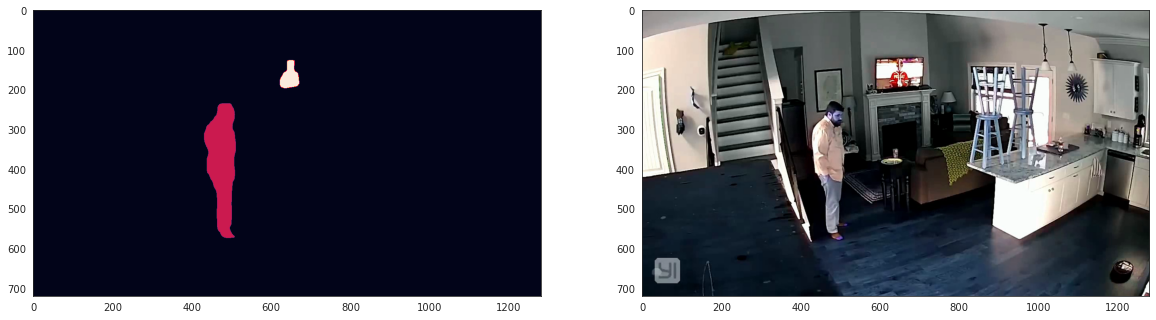

In [29]:
f,ax = plt.subplots(1,2,figsize = (20,20))
ax = ax.flatten()
ax[0].imshow(output[10])
ax[1].imshow(frames[10])

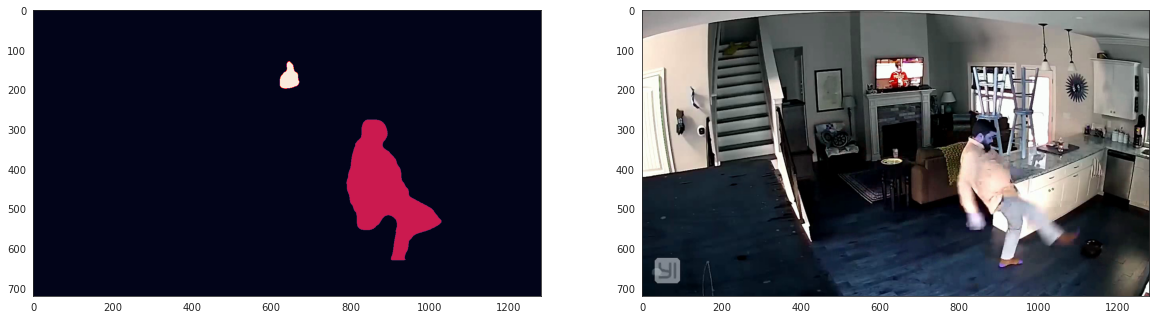

In [30]:
f,ax = plt.subplots(1,2,figsize = (20,20))
ax = ax.flatten()
ax[0].imshow(output[17])
ax[1].imshow(frames[17])

## Part 2: Image moment based analysis
Here I explore the Image moments derived from `skimage.measure.regionprops` to get differenta of the fall from no fall for the same person in the frame. There is no SORT at this time to link the identity of the person together, though this is readily applicable. 

In [31]:
from skimage import measure, color
import pandas as pd

In [55]:
dictionary = []
minimal_dictionary = []
for i in range(0, video_length):
    for region in measure.regionprops(output[i], color.rgb2gray(frames[i])):
        this_normalized_moment = region.moments_normalized
        angle = np.degrees((np.arctan2(2*this_normalized_moment[1,1], this_normalized_moment[2,0] - this_normalized_moment[0,2]))/2)
        dictionary.append({
                        "UUID": random.randint(10000,99999),
                        "Frame": i,
                        "ID": region.label, 
                        "Area": region.area, 
                        "Centroid": region.centroid, 
                        "Angle": angle, 
                        "BBOX": region.bbox, 
                        "Eccentricity": region.eccentricity})
        # The above is suitable for post-hoc image analysis. The below is the minimum input needed for the SORT algorithm. 
        minimal_dictionary.append({
                        "Frame": i,
                        "ID": region.label, 
                        "BBOX": region.bbox})

[Text(0.5, 0, 'Frame'), Text(0, 0.5, 'Angle (Degrees)')]

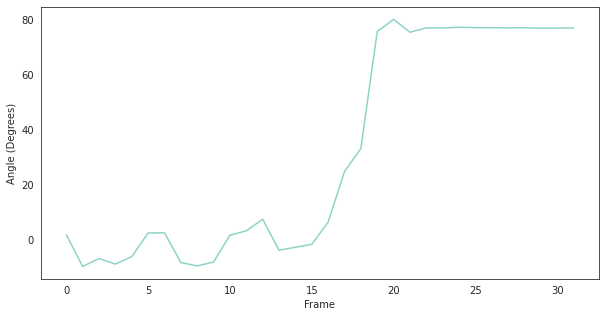

In [34]:
dude_angle = []
for diction in dictionary:
    if diction['ID'] == 1:
        dude_angle.append({"Frame": diction['Frame'],"Angle": diction['Angle']})

dude_frame = pd.DataFrame(dude_angle)
f,ax = plt.subplots(1, figsize = (10,5))
sns.set_style("white")
ax.plot(dude_frame['Frame'], dude_frame['Angle'])
ax.set(xlabel = 'Frame', ylabel = 'Angle (Degrees)')

## Part 3: Assigning SORT to each person identified
In the example video `0026.mp4` in the `/fall/` database, there are 2 people that are identified. One on the TV and one person who is slipping and falling. The outcome of the SORT approach is to assign a track identity to each person identified. 

In [69]:
# This is the dictionary we're going to be drawing tracking identities from. 
print("This dictionary has {} items of".format(len(dictionary)), 'format:')
minimal_dictionary[0]

This dictionary has 55 items of format:


{'Frame': 0, 'ID': 1, 'BBOX': (230, 428, 568, 514)}

In [74]:
# As you can note above, the BBOX is a tuple. The `Sort.py` library accepts bbox'es in the following format:
# Detections: 
    # np.array([[x1,y1,x2,y2,score, label],
    #           [x1,y1,x2,y2,score, label],
    #           ...])
    # Label must be an integer value
# Therefore, the bboxes need to be collated to create tracks.
# It should look something like this: 
    # Frame BBOX
    # 0     [[230 428 568 514   0   1]
    #       [ 126 625 196 672   0   2]
    #       [ 131 643 188 668   0   5]]
    #
    # 1     [[124 622 194 670   0   1]
    #       [ 235 428 568 511   0   2]]
    # 
    # 2     [[124 621 197 676   0   1]
    #       [ 235 428 568 510   0   2]]

identities = []
tracked_bboxes = []
Sorter = Sort(max_age = video_length, min_hits = 1, iou_threshold = 0.01)
for frame, entry in groupby(minimal_dictionary, key = lambda x:x['Frame']):
    entry_list = []
    for item in entry:
        lst = list(item['BBOX'])
        lst.extend([0, item['ID']])
        entry_list.append(lst)
    track_bbs_ids = Sorter.update(np.array(entry_list))
    for objects in track_bbs_ids:
        r0, c0, r1, c1, ID, label = objects.tolist()
        for region in measure.regionprops(output[frame], color.rgb2gray(frames[frame])):
            if region.label == label:
                this_normalized_moment = region.moments_normalized
                angle = np.degrees((np.arctan2(2*this_normalized_moment[1,1], this_normalized_moment[2,0] - this_normalized_moment[0,2]))/2)
                tracked_bboxes.append({'Frame': frame, 
                                        'ID': int(label), 
                                        'Track ID': int(ID), 
                                        'BBOX': region.bbox,
                                        'Angle': angle,
                                        'Area': region.area, 
                                        'Eccentricity': region.eccentricity, 
                                        'Perimeter': region.perimeter})
        identities.append({'Frame': frame, 'Track ID': ID})

In [75]:
output_data = pd.DataFrame(identities)
for track, df in output_data.groupby('Track ID'):
    print({'Track ID': track, 'In frames': df['Frame'].tolist()})

{'Track ID': 56.0, 'In frames': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]}
{'Track ID': 57.0, 'In frames': [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21]}
{'Track ID': 58.0, 'In frames': [0]}
{'Track ID': 60.0, 'In frames': [17]}


### Next Steps
1. Derive Rate of change of fall angle for tracked object

In [106]:
class ChainedAssignent:
    def __init__(self, chained=None):
        acceptable = [None, 'warn', 'raise']
        assert chained in acceptable, "chained must be in " + str(acceptable)
        self.swcw = chained

    def __enter__(self):
        self.saved_swcw = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = self.swcw
        return self

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = self.saved_swcw

In [115]:
tracking_table = pd.DataFrame(tracked_bboxes)
test_table = tracking_table.loc[(tracking_table['Track ID'] == 56), :]
with ChainedAssignent():
    test_table['Rate of Change'] = tracking_table.loc[(tracking_table['Track ID'] == 56), :]['Angle'].pct_change(5, fill_method = 'ffill')
test_table['Slip-Fall'] = np.where(test_table['Rate of Change'] < -10, 'Falling', 'Fine')
test_table

/home/ubuntu/anaconda3/envs/YOLACT/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Frame,ID,Track ID,BBOX,Angle,Area,Eccentricity,Perimeter,Rate of Change,Slip-Fall
2,0,1,56,"(230, 428, 568, 514)",1.739717,18653,0.976677,788.374675,NaN,Fine
4,1,2,56,"(235, 428, 568, 511)",1.616410,18019,0.978590,784.132034,NaN,Fine
6,2,2,56,"(235, 428, 568, 510)",1.811332,18020,0.978603,780.333044,NaN,Fine
8,3,2,56,"(235, 428, 574, 509)",2.153431,18209,0.979452,791.646753,NaN,Fine
10,4,2,56,"(235, 428, 574, 509)",2.400279,18228,0.979507,791.989899,NaN,Fine
12,5,1,56,"(235, 428, 574, 508)",2.413057,18158,0.979504,788.575685,0.387040,Fine
13,6,1,56,"(235, 428, 574, 509)",2.470828,18179,0.979595,787.918831,0.528590,Fine
15,7,2,56,"(235, 428, 574, 509)",2.359644,18010,0.979794,791.646753,0.302712,Fine
17,8,2,56,"(235, 428, 568, 509)",2.002586,17873,0.978746,777.404112,-0.070049,Fine
19,9,2,56,"(235, 429, 568, 509)",1.780468,17774,0.978696,777.989899,-0.258224,Fine


In [116]:
tracking_table = pd.DataFrame(tracked_bboxes)
test_table = tracking_table.loc[(tracking_table['Track ID'] == 57), :]
with ChainedAssignent():
    test_table['Rate of Change'] = tracking_table.loc[(tracking_table['Track ID'] == 57), :]['Angle'].pct_change(5, fill_method = 'ffill')
test_table['Slip-Fall'] = np.where(test_table['Rate of Change'] < -10, 'Falling', 'Fine')
test_table

/home/ubuntu/anaconda3/envs/YOLACT/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Frame,ID,Track ID,BBOX,Angle,Area,Eccentricity,Perimeter,Rate of Change,Slip-Fall
1,0,2,57,"(126, 625, 196, 672)",-0.834021,1440,0.852345,340.858910,NaN,Fine
3,1,1,57,"(124, 622, 194, 670)",-9.785391,2335,0.777691,207.296465,NaN,Fine
5,2,1,57,"(124, 621, 197, 676)",-6.905257,2539,0.749866,219.438600,NaN,Fine
7,3,1,57,"(126, 623, 198, 673)",-8.919828,2378,0.797114,209.438600,NaN,Fine
9,4,1,57,"(127, 623, 197, 674)",-6.221094,2237,0.766271,206.367532,NaN,Fine
11,5,2,57,"(126, 624, 197, 669)",-8.726011,2127,0.821844,201.781746,9.462584,Fine
14,7,1,57,"(127, 624, 197, 671)",-8.356007,2135,0.791281,203.539105,-0.146073,Fine
16,8,1,57,"(127, 622, 197, 673)",-9.592536,2318,0.735812,205.195959,0.389164,Fine
18,9,1,57,"(127, 622, 198, 673)",-8.169772,2320,0.760562,208.953319,-0.084089,Fine
20,10,2,57,"(126, 622, 197, 671)",-9.217622,2292,0.784453,210.468037,0.481672,Fine
